## Setup

In [1]:
from shared.preface import *
import shared.functions as fct

baryons = True
if baryons:
    sim = 'L025N376'
    SIM_TYPE = 'Hydro_Model_2/SigmaConstant00'
else:
    sim = 'L025N752'
    SIM_TYPE = 'DMONLY/SigmaConstant00'


PRE = PRE(
    sim=sim, 
    z0_snap=36, z4_snap=13, DM_lim=1000,
    sim_dir=SIM_ROOT, sim_ver=SIM_TYPE,
    phis=10, thetas=10, vels=100
)


def read_PartTypes(snap, halo_ID, fname, sim_dir, out_dir):

    # ---------------- #
    # Open data files. #
    # ---------------- #

    snaps = h5py.File(f'{sim_dir}/snapshot_{snap}.hdf5')
    group = h5py.File(f'{sim_dir}/subhalo_{snap}.catalog_groups')
    parts = h5py.File(f'{sim_dir}/subhalo_{snap}.catalog_particles')
    props = h5py.File(f'{sim_dir}/subhalo_{snap}.properties')

    # Positions.
    a = snaps["/Header"].attrs["Scale-factor"]
    posT0 = snaps['PartType0/Coordinates'][:][:] * a  # Gas
    posT1 = snaps['PartType1/Coordinates'][:][:] * a  # Dark Matter
    posT4 = snaps['PartType4/Coordinates'][:][:] * a  # Stars
    posT5 = snaps['PartType5/Coordinates'][:][:] * a  # Black Holes

    # Critical M_200 of halos.
    m200c = props['Mass_200crit'][:] * 1e10  # now in Msun
    m200c[m200c <= 0] = 1
    m200c = np.log10(m200c)  

    print(f'HALO MASS: {m200c[halo_ID]}')

    # ------------------------------------------------- #
    # Find ALL particles gravitationally bound to halo. #
    # ------------------------------------------------- #

    # Indices of particles in halo.
    halo_start_pos = group["Offset"][halo_ID]
    halo_end_pos = group["Offset"][halo_ID + 1]
    AllPart_IDs_in_halo = parts["Particle_IDs"][halo_start_pos:halo_end_pos]
    
    # Indices of individual particle types present in halo.
    PartType_indices_in_halo_l = []
    for PT_num in (0,1,4,5):
        PartTypeX_from_snap = snaps[f'PartType{PT_num}/ParticleIDs'][...]

        # Get indices of elements, which are present in both arrays.
        _, _, PT0_indices = np.intersect1d(
            AllPart_IDs_in_halo, PartTypeX_from_snap, 
            assume_unique=True, return_indices=True
        )
        PartType_indices_in_halo_l.append(PT0_indices)
    
    # Convert to numpy array.
    # PartType_indices_in_halo = np.array(PartType_indices_in_halo_l)

    # ---------------------------------------------------- #
    # Save ALL particle positions centered on CoP of halo. #
    # ---------------------------------------------------- #

    CoP = np.zeros((len(m200c), 3))
    CoP[:, 0] = props["Xcminpot"][:]
    CoP[:, 1] = props["Ycminpot"][:]
    CoP[:, 2] = props["Zcminpot"][:]
    CoP_halo = CoP[halo_ID, :]

    # x,y,z of each particle type.
    GAS_pos = (posT0[PartType_indices_in_halo_l[0]] - CoP_halo)*1e3
    DM_pos = (posT1[PartType_indices_in_halo_l[1]] - CoP_halo)*1e3
    STARS_pos = (posT4[PartType_indices_in_halo_l[2]] - CoP_halo)*1e3
    BHs_pos = (posT5[PartType_indices_in_halo_l[3]] - CoP_halo)*1e3
    
    np.save(f'{out_dir}/GAS_pos_{fname}.npy', GAS_pos)
    np.save(f'{out_dir}/DM_pos_{fname}.npy', DM_pos)
    np.save(f'{out_dir}/STARS_pos_{fname}.npy', STARS_pos)
    np.save(f'{out_dir}/BHs_pos_{fname}.npy', BHs_pos)

********************* Initialization *********************
# Initial conditions for neutrinos:
PHIs = 10, THETAs=10, Vs=100
Total neutrinos: 10000
# Simulation parameters:
Simulation box: L025N376
Snapshot from 0036 (z=0) to 0013 (z=4)
Pre/Sim CPUs 0/0
DM limit for cells: 1000
# File management:
Box files directory: 
 /projects/0/einf180/Tango_sims/L025N376/Hydro_Model_2/SigmaConstant00
Output directory: 
 /gpfs/home4/zimmer/neutrino_clustering_V2/L025N376/Hydro_Model_2/SigmaConstant00
**********************************************************


In [ ]:
with h5py.File(f'{PRE.SIM_DIR}/snapshot_0036.hdf5') as snap:
    print(snap.keys())
    # print(snap['PartType4'].keys())

## Visualizations of halos with baryons.

HALO MASS: 11.859228395990751


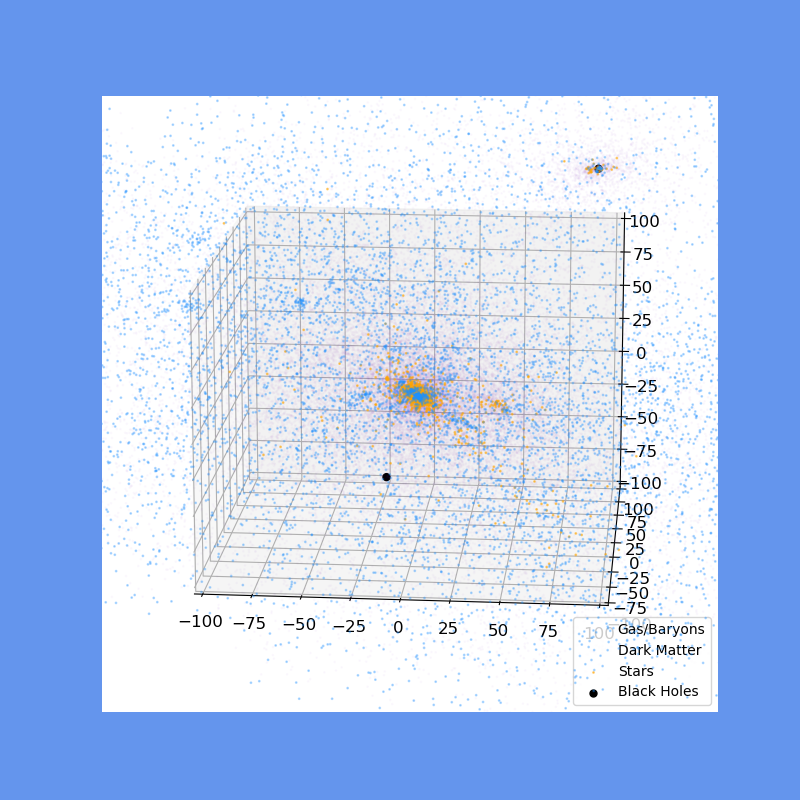

In [3]:
%matplotlib widget

# Make temporary folder to store files, s.t. parallel runs don't clash.
rand_code = ''.join(
    random.choices(string.ascii_uppercase + string.digits, k=4)
)
TEMP_DIR = f'{PRE.OUT_DIR}/temp_data_{rand_code}'
os.makedirs(TEMP_DIR)

snap = '0036'
halo_ID = 40
fname = f'origID{halo_ID}_snap_{snap}'
read_PartTypes(snap, halo_ID, fname, PRE.SIM_DIR, TEMP_DIR)

GAS_pos = np.load(f'{TEMP_DIR}/GAS_pos_{fname}.npy')
DM_pos = np.load(f'{TEMP_DIR}/DM_pos_{fname}.npy')
STARS_pos = np.load(f'{TEMP_DIR}/STARS_pos_{fname}.npy')
BHs_pos = np.load(f'{TEMP_DIR}/BHs_pos_{fname}.npy')
ALL_pos = [GAS_pos, DM_pos, STARS_pos, BHs_pos]

fig = plt.figure()
fig.patch.set_facecolor('cornflowerblue')
ax = fig.add_subplot(111, projection='3d')

alphas = [0.3, 0.02, 0.5, 1]
colors = ['dodgerblue', 'blueviolet', 'orange', 'black']
labels = ['Gas/Baryons', 'Dark Matter', 'Stars', 'Black Holes']
for i, (alpha, col, lab, pos) in enumerate(
    zip(alphas, colors, labels, ALL_pos)
):

    # if i==1:
    #     continue
    
    if i==3:
        dot_size = 25
    else:
        dot_size = 1

    skip = 2
    x, y, z = pos[:,0][0::skip], pos[:,1][0::skip], pos[:,2][0::skip]
    ax.scatter(x, y, z, alpha=alpha, c=col, s=dot_size, label=lab)

zoom = 100
ax.set_xlim(-zoom,zoom)
ax.set_ylim(-zoom,zoom)
ax.set_zlim(-zoom,zoom)

ax.view_init(elev=15, azim=-85)
lgnd = plt.legend(loc="lower right", scatterpoints=1, fontsize=10)
# for i in (0,1,2,3):

#     if i==1:
#         continue

#     lgnd.legendHandles[i]._sizes = [10]
plt.show()

# Remove temporary folder with all individual neutrino files.
shutil.rmtree(TEMP_DIR)